# Gut Microbiome Machine Learning Pipeline
Feature Engineering & Disease vs Healthy Classification Models

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split, cross_val_predict)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, balanced_accuracy_score,make_scorer)

sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# 1. Load Preprocessed Data from EDA

In [2]:
# Define paths (assuming EDA script has been run)
data_dir = "data"
RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")

# Ensure ML results directory exists
ML_FIGS = os.path.join(RESULTS, "ml_figures")
ML_TABLES = os.path.join(RESULTS, "ml_tables")
os.makedirs(ML_FIGS, exist_ok=True)
os.makedirs(ML_TABLES, exist_ok=True)

In [3]:
# Load preprocessed data from EDA
print("Loading preprocessed data from EDA...")

ab_clr = pd.read_csv(os.path.join(TABLES, "abundance_clr.csv"), index_col=0)
meta = pd.read_csv(os.path.join(TABLES, "metadata_with_disease_groups.csv"), index_col=0)
alpha = pd.read_csv(os.path.join(TABLES, "alpha_diversity.csv"), index_col=0)

# Load original relative abundance for feature engineering
ab_rel = pd.read_csv(os.path.join(TABLES, "abundance_filtered_relative.csv"), index_col=0)

print(f"\nLoaded data:")
print(f"  CLR-transformed abundances: {ab_clr.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Alpha diversity: {alpha.shape}")
print(f"  Relative abundances: {ab_rel.shape}")

# Align all datasets
common_idx = ab_clr.index.intersection(meta.index).intersection(alpha.index)
ab_clr = ab_clr.loc[common_idx]
ab_rel = ab_rel.loc[common_idx]
meta = meta.loc[common_idx]
alpha = alpha.loc[common_idx]

print(f"\nAfter alignment: {len(common_idx)} samples")

# Create binary labels: Healthy (0) vs Disease (1)
y = (meta['health_status'] == 'Disease').astype(int).values

print(f"\nClass distribution (full dataset):")
print(f"  Healthy: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Disease: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")


Loading preprocessed data from EDA...

Loaded data:
  CLR-transformed abundances: (1831, 362)
  Metadata: (1831, 28)
  Alpha diversity: (1831, 5)
  Relative abundances: (1831, 362)

After alignment: 1831 samples

Class distribution (full dataset):
  Healthy: 642 (35.1%)
  Disease: 1189 (64.9%)


# 2. Train/Test Split (Held-out Test Set)

In [4]:

print("CREATING TRAIN/TEST SPLIT")

train_idx, test_idx = train_test_split(
    np.arange(len(y)),
    test_size=0.2,
    stratify=y,
    random_state=2025
)

y_train = y[train_idx]
y_test = y[test_idx]

print(f"\nTraining set:")
print(f"  Total: {len(y_train)} samples")
print(f"  Healthy: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"  Disease: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")

print(f"\nTest set (held-out):")
print(f"  Total: {len(y_test)} samples")
print(f"  Healthy: {(y_test==0).sum()} ({(y_test==0).mean()*100:.1f}%)")
print(f"  Disease: {(y_test==1).sum()} ({(y_test==1).mean()*100:.1f}%)")

# Store indices for later use
sample_indices = {
    'train': train_idx,
    'test': test_idx
}


CREATING TRAIN/TEST SPLIT

Training set:
  Total: 1464 samples
  Healthy: 513 (35.0%)
  Disease: 951 (65.0%)

Test set (held-out):
  Total: 367 samples
  Healthy: 129 (35.1%)
  Disease: 238 (64.9%)


# 2. Feature Engineering

In [5]:
def engineer_ratio_features(ab_rel, top_n=50):
    """
    Create ratio features between abundant taxa.
    These can capture ecological relationships.
    """
    print("\nEngineering ratio features...")

    # Select top N most abundant taxa
    mean_abundance = ab_rel.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    ratio_features = pd.DataFrame(index=ab_rel.index)

    # Create key ratios
    for i, taxon1 in enumerate(top_taxa[:10]):
        for taxon2 in top_taxa[i+1:15]:
            ratio_name = f"ratio_{taxon1[:20]}_{taxon2[:20]}"
            ratio_features[ratio_name] = np.log10(
                (ab_rel[taxon1] + 1e-6) / (ab_rel[taxon2] + 1e-6)
            )

    print(f"  Created {ratio_features.shape[1]} ratio features")
    return ratio_features


In [6]:
def engineer_clinical_features(meta):
    """
    Extract and engineer features from clinical metadata.
    """
    print("\nEngineering clinical features...")

    clinical_features = pd.DataFrame(index=meta.index)
    n_features = 0

    # 1. BMI features
    if 'BMI' in meta.columns:
        clinical_features['BMI'] = meta['BMI'].astype(float)
        clinical_features['is_obese'] = (meta['BMI'] >= 30).astype(float)
        clinical_features['is_overweight'] = ((meta['BMI'] >= 25) & (meta['BMI'] < 30)).astype(float)
        n_features += 3
        print(f"  ✓ BMI features: {meta['BMI'].notna().sum()} samples with data")

    # 2. Age categories
    if 'age_category' in meta.columns:
        age_dummies = pd.get_dummies(meta['age_category'], prefix='age', drop_first=True)
        clinical_features = pd.concat([clinical_features, age_dummies], axis=1)
        n_features += age_dummies.shape[1]
        print(f"  ✓ Age categories: {age_dummies.shape[1]} features")

    # 3. Gender
    if 'gender' in meta.columns:
        clinical_features['is_male'] = (meta['gender'].str.lower() == 'male').astype(float)
        n_features += 1
        print(f"  ✓ Gender: {clinical_features['is_male'].notna().sum()} samples")

    # 4. Metabolic markers (z-scored)
    metabolic_markers = ['triglycerides', 'hba1c', 'LDL', 'HDL', 'hsCRP']
    for marker in metabolic_markers:
        if marker in meta.columns:
            values = meta[marker].astype(float)
            if values.notna().sum() > 10:  # Only if enough data
                mean = values.mean()
                std = values.std()
                if std > 0:
                    clinical_features[f'{marker}_zscore'] = (values - mean) / std
                    n_features += 1
                    print(f"  ✓ {marker}: {values.notna().sum()} samples")

    # 5. Smoking status
    if 'smoke' in meta.columns:
        clinical_features['is_smoker'] = meta['smoke'].notna().astype(float)
        n_features += 1

    # 6. Antibiotic use
    if 'antibiotic_use' in meta.columns:
        clinical_features['antibiotic_yes'] = (meta['antibiotic_use'] == 'yes').astype(float)
        clinical_features['antibiotic_unknown'] = (meta['antibiotic_use'] == 'unknown').astype(float)
        n_features += 2
        print(f"  ✓ Antibiotics: yes={clinical_features['antibiotic_yes'].sum()}, "
              f"unknown={clinical_features['antibiotic_unknown'].sum()}")

    # 7. Country/Region (if available)
    if 'country' in meta.columns:
        country_counts = meta['country'].value_counts()
        common_countries = country_counts[country_counts > 50].index
        if len(common_countries) > 1:
            meta['country_grouped'] = meta['country'].apply(
                lambda x: x if x in common_countries else 'other'
            )
            country_dummies = pd.get_dummies(meta['country_grouped'], prefix='country', drop_first=True)
            clinical_features = pd.concat([clinical_features, country_dummies], axis=1)
            n_features += country_dummies.shape[1]
            print(f"  ✓ Country: {country_dummies.shape[1]} features")

    print(f"\nTotal clinical features: {n_features}")

    return clinical_features


In [7]:
def combine_feature_sets(ab_clr, alpha, clinical_features=None, ratio_features=None):
    """
    Combine different feature sets into a single matrix.
    """
    print("\nCombining feature sets...")

    feature_sets = [ab_clr]
    feature_names = ['microbiome_clr']

    # Add alpha diversity
    if alpha is not None:
        alpha_subset = alpha[['richness', 'shannon', 'simpson']]
        feature_sets.append(alpha_subset)
        feature_names.append('alpha_diversity')

    # Add ratio features
    if ratio_features is not None:
        feature_sets.append(ratio_features)
        feature_names.append('ratio_features')

    # Add clinical features
    if clinical_features is not None:
        feature_sets.append(clinical_features)
        feature_names.append('clinical')

    # Combine
    X_combined = pd.concat(feature_sets, axis=1)

    # Handle missing values
    # Binary features: fill with 0
    # Continuous: fill with median
    for col in X_combined.columns:
        if X_combined[col].isna().any():
            if X_combined[col].nunique() <= 2:
                X_combined[col] = X_combined[col].fillna(0)
            else:
                X_combined[col] = X_combined[col].fillna(X_combined[col].median())

    print(f"\nCombined feature matrix: {X_combined.shape}")
    print(f"Feature sets included: {', '.join(feature_names)}")
    print(f"Missing values remaining: {X_combined.isna().sum().sum()}")

    print("Total samples and features:", X_combined.shape)

    return X_combined


In [8]:
# Create feature sets
print("FEATURE ENGINEERING")


ratio_features = engineer_ratio_features(ab_rel, top_n=50)
clinical_features = engineer_clinical_features(meta)

# Create different feature combinations
X_microbiome = ab_clr.copy()
X_microbiome_alpha = combine_feature_sets(ab_clr, alpha, None, None)
X_full = combine_feature_sets(ab_clr, alpha, clinical_features, ratio_features)

print(f"\nFeature matrices created:")
print(f"  1. Microbiome-only (CLR):                    {X_microbiome.shape}")
print(f"  2. Microbiome + Alpha diversity:             {X_microbiome_alpha.shape}")
print(f"  3. Full (microbiome + alpha + clinical):     {X_full.shape}")


FEATURE ENGINEERING

Engineering ratio features...
  Created 95 ratio features

Engineering clinical features...
  ✓ BMI features: 1310 samples with data
  ✓ Age categories: 1 features
  ✓ Gender: 1831 samples
  ✓ triglycerides: 844 samples
  ✓ hba1c: 839 samples
  ✓ LDL: 841 samples
  ✓ hsCRP: 829 samples
  ✓ Antibiotics: yes=783.0, unknown=104.0
  ✓ Country: 2 features

Total clinical features: 14

Combining feature sets...

Combined feature matrix: (1831, 365)
Feature sets included: microbiome_clr, alpha_diversity
Missing values remaining: 0
Total samples and features: (1831, 365)

Combining feature sets...

Combined feature matrix: (1831, 474)
Feature sets included: microbiome_clr, alpha_diversity, ratio_features, clinical
Missing values remaining: 0
Total samples and features: (1831, 474)

Feature matrices created:
  1. Microbiome-only (CLR):                    (1831, 362)
  2. Microbiome + Alpha diversity:             (1831, 365)
  3. Full (microbiome + alpha + clinical):     (18

# 4. Model Training & Evaluation Functions

In [9]:
def train_and_evaluate_model(X, y, train_idx, test_idx, model_type='logistic',
                            n_cv_folds=5, feature_selection=None, n_features=100, logistic_penalty = 'l2', rf_n_estimators=200,
            rf_max_depth=10):
    """
    Train and evaluate a model with proper train/test split.

    Parameters:
    -----------
    X : DataFrame - Feature matrix
    y : array - Binary labels (0=Healthy, 1=Disease)
    train_idx : array - Training set indices
    test_idx : array - Test set indices
    model_type : str - 'logistic', or 'random_forest'
    n_cv_folds : int - Number of cross-validation folds (on training set only)
    feature_selection : str - 'univariate' or None
    n_features : int - Number of features to select
    """

    # Split data
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train_set = y[train_idx]
    y_test_set = y[test_idx]

    # Feature selection (fit on training set only)
    selected_features = None
    if feature_selection == 'univariate':
        print(f"\nPerforming univariate feature selection (top {n_features})...")
        selector = SelectKBest(f_classif, k=min(n_features, X_train.shape[1]))
        X_train_transformed = selector.fit_transform(X_train.values, y_train_set)
        X_test_transformed = selector.transform(X_test.values)

        selected_features = X_train.columns[selector.get_support()].tolist()
        print(f"  Selected {len(selected_features)} features")

        X_train = pd.DataFrame(X_train_transformed,
                              index=X_train.index,
                              columns=selected_features)
        X_test = pd.DataFrame(X_test_transformed,
                             index=X_test.index,
                             columns=selected_features)

    # Initialize model
    if model_type == 'logistic':
        model = LogisticRegressionCV(
            cv=5,
            penalty=logistic_penalty,
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1,
            scoring='roc_auc'
        )
        model_name = 'Logistic Regression (L2)'
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )
        model_name = 'Random Forest'

    print(f"\nModel: {model_name}")
    print(f"Training samples: {len(y_train_set)}, Test samples: {len(y_test_set)}")

    # Cross-validation on TRAINING SET ONLY
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"\nPerforming {n_cv_folds}-fold cross-validation on training set...")
    cv_results = cross_validate(
        model, X_train.values, y_train_set,
        cv=cv,
        scoring=scoring,
        return_train_score=False,  # Only validation scores
        n_jobs=-1
    )

    # Print CV results (validation during training)
    print(f"\nCross-Validation Results (on training set):")
    print(f"{'Metric':<15} {'CV Mean':<20}")


    cv_results_dict = {}
    for metric in scoring.keys():
        cv_mean = cv_results[f'test_{metric}'].mean()
        cv_std = cv_results[f'test_{metric}'].std()

        cv_results_dict[metric] = {
            'cv_mean': cv_mean,
            'cv_std': cv_std
        }

        print(f"{metric:<15} {cv_mean:.3f} ± {cv_std:.3f}")

    # Train final model on FULL training set
    print(f"\nTraining final model on full training set...")
    model.fit(X_train.values, y_train_set)

    # Evaluate on HELD-OUT TEST SET
    print(f"\nEvaluating on held-out test set...")
    y_test_pred = model.predict(X_test.values)
    y_test_prob = model.predict_proba(X_test.values)[:, 1]

    # Calculate test metrics
    test_results = {
        'roc_auc': roc_auc_score(y_test_set, y_test_prob),
        'accuracy': (y_test_set == y_test_pred).mean(),
        'balanced_acc': balanced_accuracy_score(y_test_set, y_test_pred),
        'precision': ((y_test_pred == 1) & (y_test_set == 1)).sum() / max((y_test_pred == 1).sum(), 1),
        'recall': ((y_test_pred == 1) & (y_test_set == 1)).sum() / max((y_test_set == 1).sum(), 1),
    }
    test_results['f1'] = 2 * test_results['precision'] * test_results['recall'] / max(test_results['precision'] + test_results['recall'], 1e-10)

    print(f"\nTest Set Results:")
    print(f"{'Metric':<15} {'Test Score':<20}")

    for metric, value in test_results.items():
        print(f"{metric:<15} {value:.3f}")
        cv_results_dict[metric]['test_score'] = value

    # Calculate generalization gap
    generalization_gap = cv_results_dict['roc_auc']['cv_mean'] - test_results['roc_auc']
    print(f"\nGeneralization Analysis:")
    print(f"  CV AUC (training):  {cv_results_dict['roc_auc']['cv_mean']:.3f}")
    print(f"  Test AUC (held-out): {test_results['roc_auc']:.3f}")
    print(f"  Gap: {generalization_gap:+.3f}")

    if abs(generalization_gap) > 0.05:
        if generalization_gap > 0:
            print(f"Model may be slightly overfit to training data")
        else:
            print(f"Model generalizes well (test better than CV)")
    else:
        print(f"Good generalization")

    # Extract feature importance
    feature_importance = None
    if model_type == 'logistic':
        coefs = model.coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nTop 15 Features (Logistic Regression Coefficients):")
        print(f"{'Feature':<50} {'Coefficient':>12} {'Direction'}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            direction = '↑ Disease' if row['coefficient'] > 0 else '↓ Disease'
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['coefficient']:>12.4f}  {direction}")

    elif model_type in ['random_forest', 'gradient_boosting']:
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Features (Feature Importance):")
        print(f"{'Feature':<50} {'Importance':>12}")
        for _, row in feature_importance.head(15).iterrows():
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'model_name': model_name,
        'cv_results': cv_results_dict,
        'y_test': y_test_set,
        'y_test_pred': y_test_pred,
        'y_test_prob': y_test_prob,
        'feature_importance': feature_importance,
        'X_train': X_train,
        'X_test': X_test,
        'selected_features': selected_features
    }


# 5. Train Different Models with Different Feature Sets
1. Only Microbiome
2. Microbiome + Alpha Diversity Features
3. Microbiome + Clinical + Alpha Diversity Features

In [10]:
results = {}


## Log Reg

In [11]:
# Model 1: Microbiome-only (CLR-transformed abundances) for Log Reg
print("MODEL 1: MICROBIOME-ONLY (CLR)")

results['microbiome_only_logreg'] = train_and_evaluate_model(
    X_microbiome, y, train_idx, test_idx,
    model_type='logistic',
    n_cv_folds=5
)


MODEL 1: MICROBIOME-ONLY (CLR)

Model: Logistic Regression (L2)
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.710 ± 0.026
accuracy        0.669 ± 0.027
balanced_acc    0.669 ± 0.024
precision       0.789 ± 0.015
recall          0.670 ± 0.036
f1              0.724 ± 0.026

Training final model on full training set...



Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.654
accuracy        0.597
balanced_acc    0.602
precision       0.739
recall          0.584
f1              0.653

Generalization Analysis:
  CV AUC (training):  0.710
  Test AUC (held-out): 0.654
  Gap: +0.056
Model may be slightly overfit to training data

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
Escherichia coli                                         0.0779  ↑ Disease
[Ruminococcus] gnavus                                   -0.0518  ↓ Disease
Eubacterium sp. CAG:180                                  0.0486  ↑ Disease
Lachnospira pectinoschiza                               -0.0452  ↓ Disease
Firmicutes bacterium CAG:95                             -0.0415  ↓ Disease
Parasutterella excrementihominis                        -0.

In [12]:
# Model 2: Microbiome + Alpha Diversity for Log reg
print("MODEL 2: MICROBIOME + ALPHA DIVERSITY")

results['microbiome_alpha_logreg'] = train_and_evaluate_model(
    X_microbiome_alpha, y, train_idx, test_idx,
    model_type='logistic',
    n_cv_folds=5
)


MODEL 2: MICROBIOME + ALPHA DIVERSITY

Model: Logistic Regression (L2)
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.708 ± 0.026
accuracy        0.663 ± 0.020
balanced_acc    0.662 ± 0.018
precision       0.783 ± 0.012
recall          0.665 ± 0.028
f1              0.719 ± 0.020

Training final model on full training set...



Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.653
accuracy        0.591
balanced_acc    0.596
precision       0.734
recall          0.580
f1              0.648

Generalization Analysis:
  CV AUC (training):  0.708
  Test AUC (held-out): 0.653
  Gap: +0.056
Model may be slightly overfit to training data

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
Escherichia coli                                         0.0783  ↑ Disease
[Ruminococcus] gnavus                                   -0.0515  ↓ Disease
Eubacterium sp. CAG:180                                  0.0488  ↑ Disease
Lachnospira pectinoschiza                               -0.0451  ↓ Disease
Firmicutes bacterium CAG:95                             -0.0416  ↓ Disease
[Bacteroides] pectinophilus                             -0.

In [13]:
# Model 3: Full features with feature selection for Log Reg

print("MODEL 3: FULL FEATURES (with feature selection)")


results['full_features_logreg'] = train_and_evaluate_model(
    X_full, y, train_idx, test_idx,
    model_type='logistic',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150
)


MODEL 3: FULL FEATURES (with feature selection)

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Logistic Regression (L2)
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.869 ± 0.020
accuracy        0.788 ± 0.016
balanced_acc    0.780 ± 0.016
precision       0.857 ± 0.011
recall          0.809 ± 0.017
f1              0.832 ± 0.013

Training final model on full training set...



Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.837
accuracy        0.785
balanced_acc    0.767
precision       0.838
recall          0.828
f1              0.833

Generalization Analysis:
  CV AUC (training):  0.869
  Test AUC (held-out): 0.837
  Gap: +0.032
Good generalization

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
hba1c_zscore                                             4.2207  ↑ Disease
is_overweight                                            2.1891  ↑ Disease
hsCRP_zscore                                            -1.2788  ↓ Disease
age_senior                                               0.9088  ↑ Disease
Clostridiales bacterium 1_7_47FAA                        0.2511  ↑ Disease
Ruminococcus sp. CAG:579                                -0.2507  ↓ Disease
Streptococc

## Random Forest

In [14]:
# Model 4: Microbiome-only (CLR-transformed abundances) for RF
print("MODEL 4: MICROBIOME-ONLY (CLR)")

results['microbiome_only_rf'] = train_and_evaluate_model(
    X_microbiome, y, train_idx, test_idx,
    model_type='random_forest',
    n_cv_folds=5,
    rf_n_estimators=150,
    rf_max_depth=8
)


MODEL 4: MICROBIOME-ONLY (CLR)

Model: Random Forest
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.699 ± 0.033
accuracy        0.673 ± 0.036
balanced_acc    0.636 ± 0.036
precision       0.743 ± 0.024
recall          0.759 ± 0.037
f1              0.751 ± 0.029

Training final model on full training set...



Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.660
accuracy        0.657
balanced_acc    0.623
precision       0.735
recall          0.735
f1              0.735

Generalization Analysis:
  CV AUC (training):  0.699
  Test AUC (held-out): 0.660
  Gap: +0.039
Good generalization

Top 15 Features (Feature Importance):
Feature                                              Importance
Escherichia coli                                         0.0693
Anaerostipes hadrus                                      0.0181
Streptococcus parasanguinis                              0.0175
Eubacterium sp. CAG:180                                  0.0151
Lachnospira pectinoschiza                                0.0128
Parasutterella excrementihominis                         0.0126
Eubacterium sp. CAG:38                                   0.0114
Streptococcus salivarius                                 0.0110
Oscillibacter sp. PC13                      

In [15]:
# Model 5: Microbiome + Alpha Diversity for RF
print("MODEL 5: MICROBIOME + ALPHA DIVERSITY")

results['microbiome_alpha_rf'] = train_and_evaluate_model(
    X_microbiome_alpha, y, train_idx, test_idx,
    model_type='random_forest',
    n_cv_folds=5,
    rf_n_estimators=150,
    rf_max_depth=5
)


MODEL 5: MICROBIOME + ALPHA DIVERSITY

Model: Random Forest
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.688 ± 0.045
accuracy        0.651 ± 0.027
balanced_acc    0.635 ± 0.029
precision       0.754 ± 0.023
recall          0.688 ± 0.028
f1              0.719 ± 0.023

Training final model on full training set...

Evaluating on held-out test set...



Test Set Results:
Metric          Test Score          
roc_auc         0.645
accuracy        0.599
balanced_acc    0.597
precision       0.731
recall          0.605
f1              0.662

Generalization Analysis:
  CV AUC (training):  0.688
  Test AUC (held-out): 0.645
  Gap: +0.043
Good generalization

Top 15 Features (Feature Importance):
Feature                                              Importance
Escherichia coli                                         0.0858
Anaerostipes hadrus                                      0.0265
Streptococcus parasanguinis                              0.0205
Streptococcus gordonii                                   0.0190
Eubacterium sp. CAG:180                                  0.0154
Dielma fastidiosa                                        0.0146
Oscillibacter sp. PC13                                   0.0145
Eubacterium sp. CAG:38                                   0.0141
Parasutterella excrementihominis                         0.0141
Lachnospira pect

In [16]:
# Model 6: Random Forest (full features)
print("RANDOM FOREST (full features)")

results['full_features_rf'] = train_and_evaluate_model(
    X_full, y, train_idx, test_idx,
    model_type='random_forest',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150,
    rf_n_estimators=200,
    rf_max_depth=10
)


RANDOM FOREST (full features)

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Random Forest
Training samples: 1464, Test samples: 367

Performing 5-fold cross-validation on training set...



Cross-Validation Results (on training set):
Metric          CV Mean             
roc_auc         0.919 ± 0.018
accuracy        0.886 ± 0.013
balanced_acc    0.851 ± 0.018
precision       0.871 ± 0.016
recall          0.967 ± 0.007
f1              0.917 ± 0.009

Training final model on full training set...



Evaluating on held-out test set...

Test Set Results:
Metric          Test Score          
roc_auc         0.894
accuracy        0.850
balanced_acc    0.805
precision       0.835
recall          0.958
f1              0.892

Generalization Analysis:
  CV AUC (training):  0.919
  Test AUC (held-out): 0.894
  Gap: +0.025
Good generalization

Top 15 Features (Feature Importance):
Feature                                              Importance
hba1c_zscore                                             0.2725
hsCRP_zscore                                             0.1013
is_overweight                                            0.0270
ratio_Faecalibacterium pra_Escherichia coli              0.0267
Escherichia coli                                         0.0170
ratio_Phocaeicola vulgatus_Escherichia coli              0.0132
ratio_Bacteroides uniformi_Escherichia coli              0.0130
ratio_Roseburia faecis_Escherichia coli                  0.0128
ratio_[Eubacterium] rectal_Escherichia coli 

## Model Comparison Visualizations

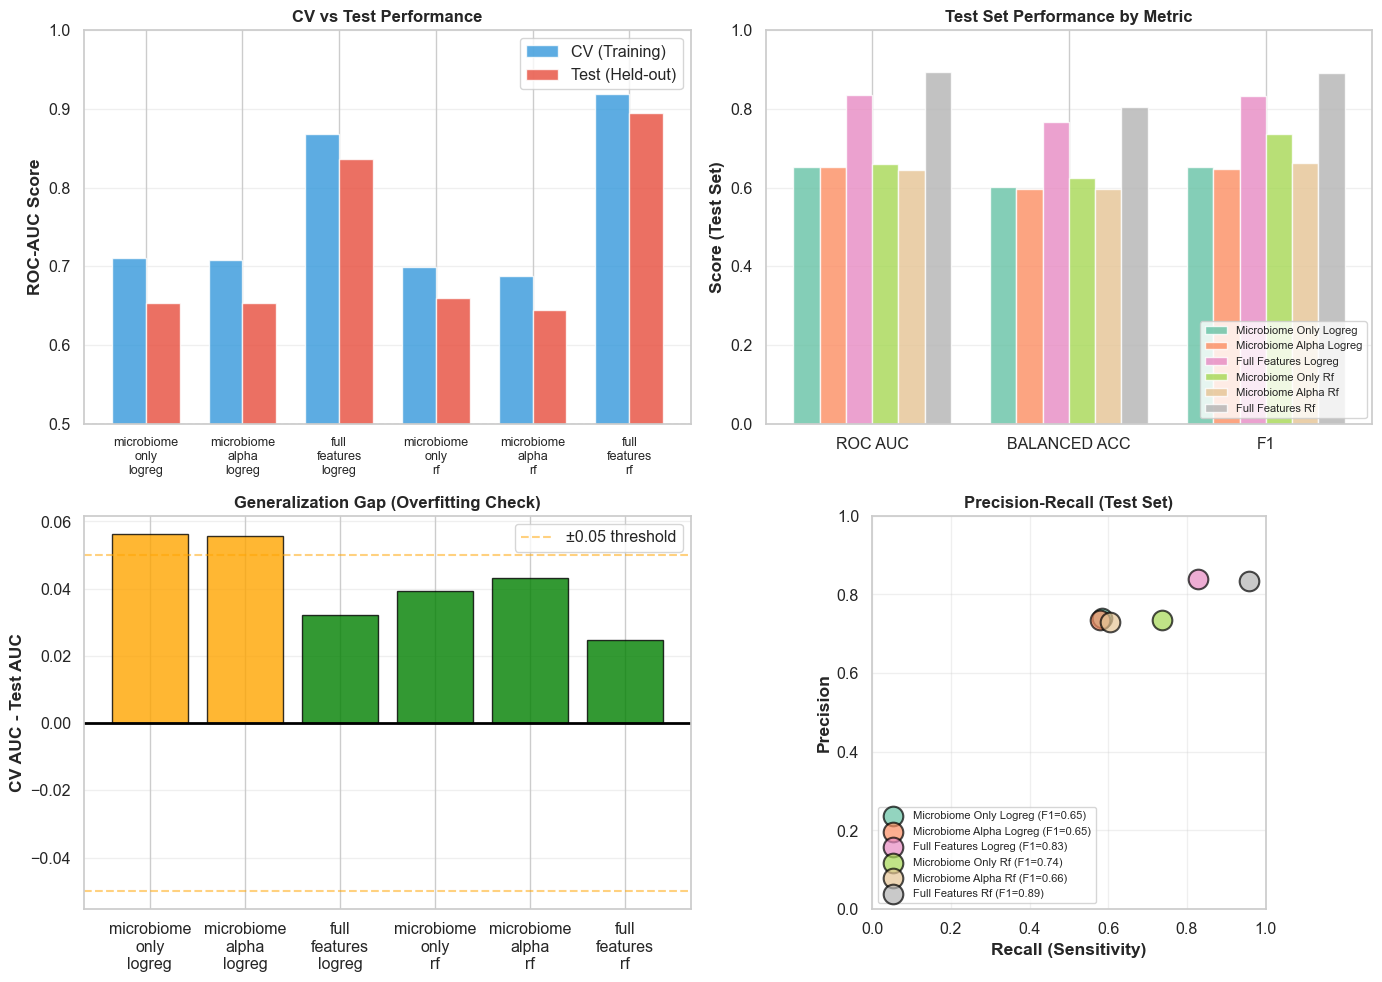

In [17]:
def plot_model_comparison(results_dict):
    """
    Create comprehensive comparison plots showing CV and Test performance.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    models = list(results_dict.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

    # 1. CV vs Test Performance Comparison
    ax = axes[0, 0]
    x = np.arange(len(models))
    width = 0.35

    cv_aucs = [results_dict[m]['cv_results']['roc_auc']['cv_mean'] for m in models]
    test_aucs = [results_dict[m]['cv_results']['roc_auc']['test_score'] for m in models]

    ax.bar(x - width/2, cv_aucs, width, label='CV (Training)', alpha=0.8, color='#3498DB')
    ax.bar(x + width/2, test_aucs, width, label='Test (Held-out)', alpha=0.8, color='#E74C3C')

    ax.set_ylabel('ROC-AUC Score', fontweight='bold')
    ax.set_title('CV vs Test Performance', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.5, 1.0])
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    # 2. Test Set Performance Across Metrics
    ax = axes[0, 1]
    x = np.arange(len(metrics))
    width = 0.8 / len(models)

    for i, (model_name, color) in enumerate(zip(models, colors)):
        values = [results_dict[model_name]['cv_results'][m]['test_score'] for m in metrics]

        ax.bar(x + i*width, values, width,
               label=model_name.replace('_', ' ').title(),
               alpha=0.8, color=color)

    ax.set_ylabel('Score (Test Set)', fontweight='bold')
    ax.set_title('Test Set Performance by Metric', fontweight='bold', fontsize=12)
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # 3. Generalization Gap Analysis
    ax = axes[1, 0]

    gaps = []
    for model_name in models:
        cv_auc = results_dict[model_name]['cv_results']['roc_auc']['cv_mean']
        test_auc = results_dict[model_name]['cv_results']['roc_auc']['test_score']
        gap = cv_auc - test_auc
        gaps.append(gap)

    colors_bars = ['green' if abs(g) < 0.05 else 'orange' if abs(g) < 0.1 else 'red' for g in gaps]
    ax.bar([m.replace('_', '\n') for m in models], gaps, alpha=0.8, color=colors_bars, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='±0.05 threshold')
    ax.axhline(y=-0.05, color='orange', linestyle='--', alpha=0.5)

    ax.set_ylabel('CV AUC - Test AUC', fontweight='bold')
    ax.set_title('Generalization Gap (Overfitting Check)', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 4. Precision-Recall on Test Set
    ax = axes[1, 1]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        precision = results_dict[model_name]['cv_results']['precision']['test_score']
        recall = results_dict[model_name]['cv_results']['recall']['test_score']
        f1 = results_dict[model_name]['cv_results']['f1']['test_score']

        ax.scatter(recall, precision, s=200, alpha=0.7, color=color,
                  label=f"{model_name.replace('_', ' ').title()} (F1={f1:.2f})",
                  edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Recall (Sensitivity)', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall (Test Set)', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'model_comparison_comprehensive.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison(results)


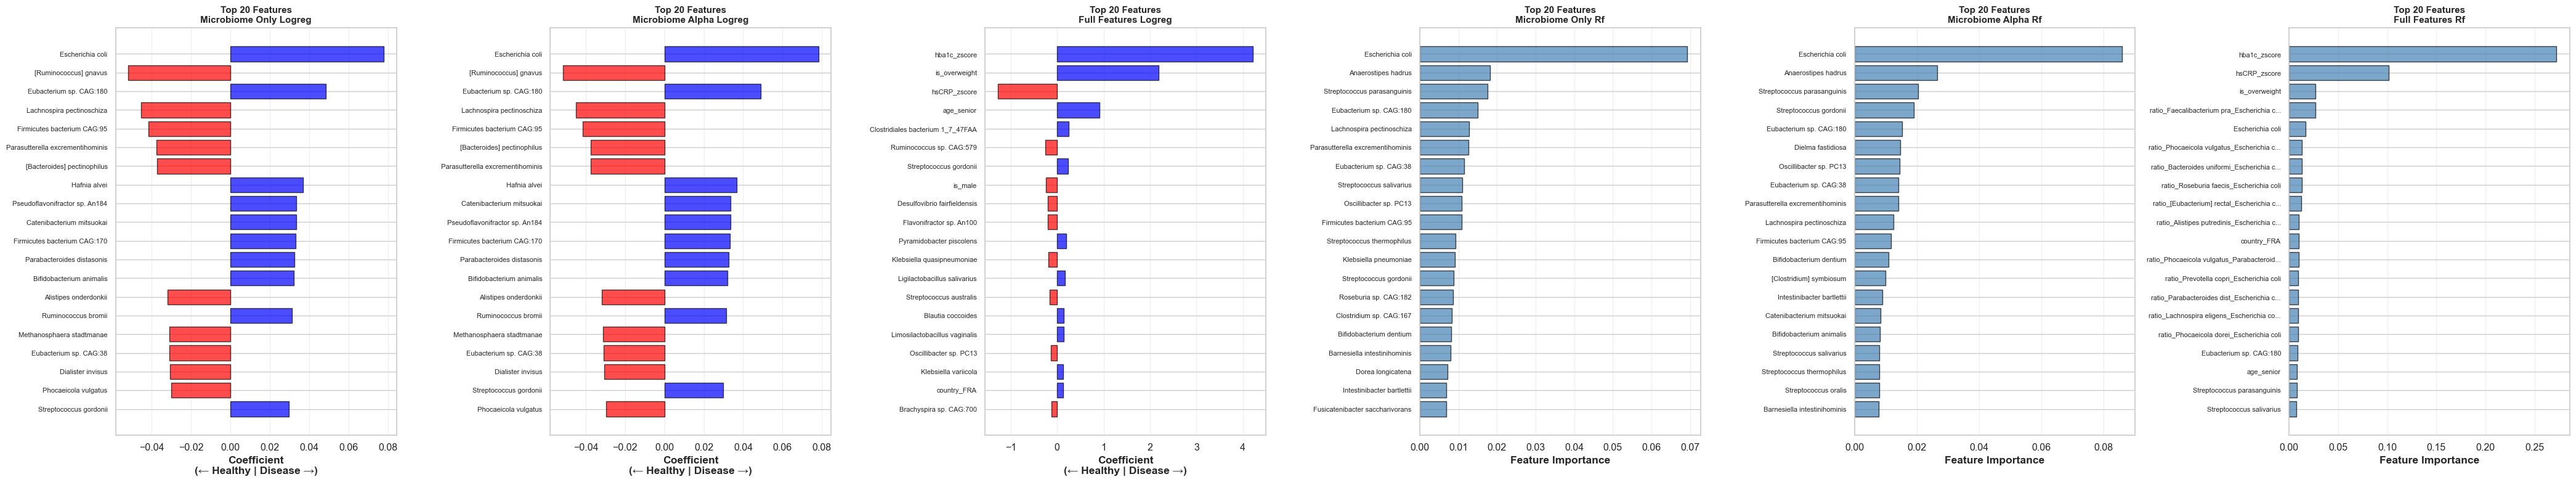

In [18]:
def plot_feature_importance_comparison(results_dict, top_n=20):
    """
    Plot top features for each model side-by-side.
    """
    # Filter models with feature importance
    models_with_fi = {k: v for k, v in results_dict.items()
                      if v['feature_importance'] is not None}

    n_models = len(models_with_fi)
    if n_models == 0:
        print("No models with feature importance to plot")
        return

    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 8))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, result) in zip(axes, models_with_fi.items()):
        fi = result['feature_importance']
        top_features = fi.head(top_n)

        if 'coefficient' in fi.columns:
            # Logistic regression
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['coefficient'], color=colors, alpha=0.7, edgecolor='black')
            ax.set_xlabel('Coefficient\n(← Healthy | Disease →)', fontweight='bold')
        else:
            # Tree-based models
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Feature Importance', fontweight='bold')

        # Shorten feature names for display
        feature_labels = [f[:40] + '...' if len(f) > 40 else f
                         for f in top_features['feature']]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=8)
        ax.invert_yaxis()
        ax.set_title(f'Top {top_n} Features\n{model_name.replace("_", " ").title()}',
                    fontweight='bold', fontsize=11)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'feature_importance_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_importance_comparison(results, top_n=20)


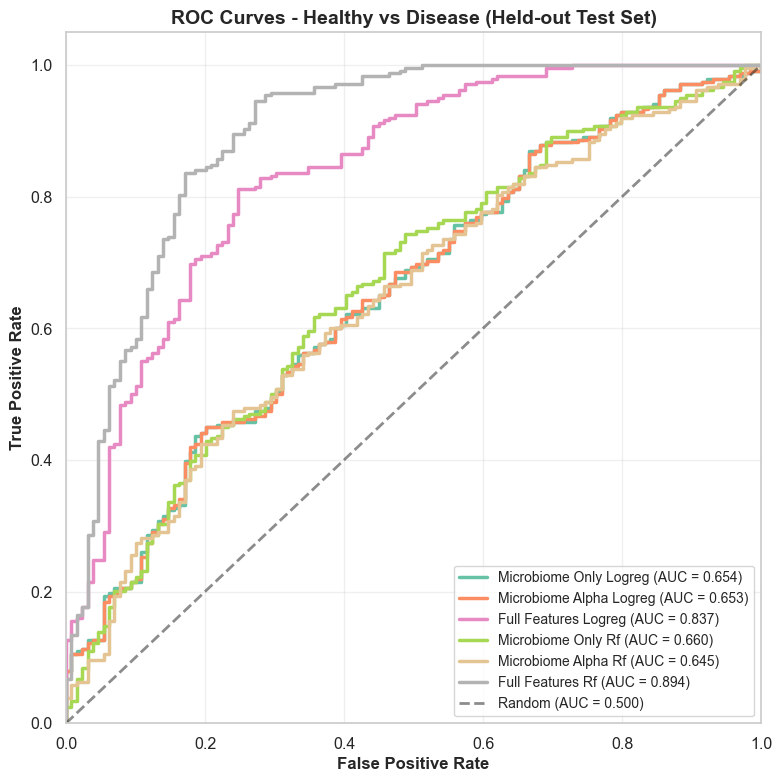

In [19]:
def plot_roc_curves_test_set(results_dict):
    """
    Plot ROC curves using the actual held-out test set predictions.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    colors = plt.cm.Set2(np.linspace(0, 1, len(results_dict)))

    for (model_name, result), color in zip(results_dict.items(), colors):
        y_test = result['y_test']
        y_prob = result['y_test_prob']

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Plot
        ax.plot(fpr, tpr, color=color, lw=2.5,
                label=f'{model_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)', alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('ROC Curves - Healthy vs Disease (Held-out Test Set)',
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'roc_curves_test_set.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_roc_curves_test_set(results)


# Disease-Specific RF Models
1. Metabolic Diseases vs Healthy
2. Cardiovascular Diseases vs Healthy
3. Disease vs Healthy

In [20]:
from sklearn.pipeline import Pipeline

def train_disease_specific_rf(X, meta, disease_group, n_cv_folds=5,
                               feature_selection=None, n_features=100, n_estimators=200,
                               max_depth=10):
    """
    Train Random Forest for specific disease group vs. controls.
    Feature selection is done WITHIN cross-validation to prevent data leakage.

    Parameters:
    -----------
    X : DataFrame - Feature matrix
    meta : DataFrame - Metadata with disease_group column
    disease_group : str - Disease group to model ('metabolic', 'cardiovascular', or 'disease')
    n_cv_folds : int - Number of cross-validation folds
    feature_selection : str - 'univariate' or None
    n_features : int - Number of features to select
    """
    print(f"TRAINING RANDOM FOREST: {disease_group.upper()} vs CONTROL")

    # Select samples
    if disease_group == 'disease':
        control_idx = meta['disease_combined'] == 'control'
        disease_idx = meta['disease_combined'] == 'disease'
    else:
        control_idx = meta['disease_group'] == 'control'
        disease_idx = meta['disease_group'] == disease_group

    selected_idx = control_idx | disease_idx

    X_subset = X.loc[selected_idx]
    y_subset = disease_idx[selected_idx].astype(int).values

    n_disease = y_subset.sum()
    n_control = (y_subset == 0).sum()

    print(f"\nDataset:")
    print(f"  Controls: {n_control}")
    print(f"  {disease_group.capitalize()}: {n_disease}")
    print(f"  Features: {X_subset.shape[1]}")
    print(f"  Class balance: {n_disease / (n_disease + n_control):.2%} disease")

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=2025,
        n_jobs=-1
    )

    # Create pipeline with feature selection INSIDE
    if feature_selection == 'univariate':
        print(f"\n✓ Feature selection will be performed WITHIN each CV fold (top {n_features})")
        print(f"  This prevents data leakage from test set\n")
        
        # Pipeline: feature selection -> model
        model = Pipeline([
            ('feature_selection', SelectKBest(f_classif, k=min(n_features, X_subset.shape[1]))),
            ('classifier', rf_model)
        ])
    else:
        model = rf_model

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"Performing {n_cv_folds}-fold cross-validation...")
    cv_results = cross_validate(
        model, X_subset.values, y_subset,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Print results
    print(f"\nCross-Validation Results:")
    print(f"{'Metric':<15} {'Train':<20} {'Test':<20}")

    results_dict = {}
    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()

        results_dict[metric] = {
            'train_mean': train_mean,
            'train_std': train_std,
            'test_mean': test_mean,
            'test_std': test_std
        }

        print(f"{metric:<15} {train_mean:.3f} ± {train_std:.3f}      "
              f"{test_mean:.3f} ± {test_std:.3f}")

    # Check overfitting
    auc_gap = results_dict['roc_auc']['train_mean'] - results_dict['roc_auc']['test_mean']
    if auc_gap > 0.1:
        print(f"\n⚠ Warning: Possible overfitting (train-test AUC gap: {auc_gap:.3f})")

    # Fit model on full dataset for feature importance
    # Note: For pipeline, we need to access the classifier step
    model.fit(X_subset.values, y_subset)

    # Extract feature importance
    if feature_selection == 'univariate':
        # Get selected features from the fitted pipeline
        selector = model.named_steps['feature_selection']
        selected_mask = selector.get_support()
        selected_features = X_subset.columns[selected_mask].tolist()
        
        # Get importance from the classifier
        classifier = model.named_steps['classifier']
        importances = classifier.feature_importances_
        
        print(f"\n✓ Selected {len(selected_features)} features on full dataset")
    else:
        selected_features = X_subset.columns.tolist()
        importances = model.feature_importances_

    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"\nTop 15 Features (Random Forest Importance):")
    print(f"{'Feature':<50} {'Importance':>12}")

    for _, row in feature_importance.head(15).iterrows():
        feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
        print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'cv_results': results_dict,
        'feature_importance': feature_importance,
        'X_train': X_subset,
        'y_train': y_subset,
        'n_control': n_control,
        'n_disease': n_disease
    }


## Train Disease Specific Models

In [21]:
# Create combined disease group
meta['disease_combined'] = meta['disease_group'].apply(
    lambda x: 'disease' if x in ['metabolic', 'cardiovascular'] else x
)

print("TRAINING DISEASE-SPECIFIC RANDOM FOREST MODELS")

results = {}


TRAINING DISEASE-SPECIFIC RANDOM FOREST MODELS


In [22]:
# Metabolic diseases (microbiome only)
print("\n\nMETABOLIC DISEASES - MICROBIOME ONLY")
results['metabolic_microbiome'] = train_disease_specific_rf(
    X_microbiome, meta,
    disease_group='metabolic',
    n_cv_folds=5,
    n_estimators=50,
    max_depth=2
    
)




METABOLIC DISEASES - MICROBIOME ONLY
TRAINING RANDOM FOREST: METABOLIC vs CONTROL

Dataset:
  Controls: 642
  Metabolic: 825
  Features: 362
  Class balance: 56.24% disease
Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.771 ± 0.018      0.675 ± 0.035
accuracy        0.692 ± 0.010      0.624 ± 0.022
balanced_acc    0.693 ± 0.013      0.623 ± 0.027
precision       0.745 ± 0.020      0.681 ± 0.034
recall          0.690 ± 0.015      0.633 ± 0.025
f1              0.716 ± 0.005      0.655 ± 0.012

Top 15 Features (Random Forest Importance):
Feature                                              Importance
Firmicutes bacterium CAG:95                              0.0617
Escherichia coli                                         0.0596
Anaerostipes hadrus                                      0.0586
[Ruminococcus] lactaris                                  0.0399
Clostridium sp. CAG:167                                  0.0384
Gemmiger formicilis                                      0.0365
Roseburia sp. CAG:309                                    0.0334
Faecalibacterium prausnitzii                             0.0287


In [23]:
# Metabolic diseases (full features)
print("\n\nMETABOLIC DISEASES - FULL FEATURES")
results['metabolic_full'] = train_disease_specific_rf(
    X_full, meta,
    disease_group='metabolic',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150,
    n_estimators=80,
    max_depth=5
)




METABOLIC DISEASES - FULL FEATURES
TRAINING RANDOM FOREST: METABOLIC vs CONTROL

Dataset:
  Controls: 642
  Metabolic: 825
  Features: 474
  Class balance: 56.24% disease

✓ Feature selection will be performed WITHIN each CV fold (top 150)
  This prevents data leakage from test set

Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.961 ± 0.003      0.903 ± 0.009
accuracy        0.905 ± 0.007      0.826 ± 0.023
balanced_acc    0.901 ± 0.008      0.820 ± 0.022
precision       0.898 ± 0.011      0.835 ± 0.024
recall          0.938 ± 0.009      0.862 ± 0.052
f1              0.918 ± 0.006      0.847 ± 0.024

✓ Selected 150 features on full dataset

Top 15 Features (Random Forest Importance):
Feature                                              Importance
hba1c_zscore                                             0.2627
hsCRP_zscore                                             0.0917
is_overweight                                            0.0470
ratio_Faecalibacterium pra_Escherichia coli              0.0432
Escherichia coli                                         0.0384
ratio_Lachnospira eligens_Escherichia coli               0.0228
ratio_Parabacteroides dist_Escherichia coli              0.0220
ratio_Bacteroides unifo

In [24]:
# Cardiovascular diseases (microbiome only)
print("\n\nCARDIOVASCULAR DISEASES - MICROBIOME ONLY")
results['cardiovascular_microbiome'] = train_disease_specific_rf(
    X_microbiome, meta,
    disease_group='cardiovascular',
    n_cv_folds=5,
    n_estimators=7,
    max_depth=2
)




CARDIOVASCULAR DISEASES - MICROBIOME ONLY
TRAINING RANDOM FOREST: CARDIOVASCULAR vs CONTROL

Dataset:
  Controls: 642
  Cardiovascular: 364
  Features: 362
  Class balance: 36.18% disease
Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.707 ± 0.013      0.605 ± 0.031
accuracy        0.636 ± 0.014      0.551 ± 0.027
balanced_acc    0.651 ± 0.010      0.553 ± 0.031
precision       0.500 ± 0.016      0.411 ± 0.025
recall          0.704 ± 0.080      0.561 ± 0.098
f1              0.582 ± 0.021      0.471 ± 0.048

⚠ Warning: Possible overfitting (train-test AUC gap: 0.102)

Top 15 Features (Random Forest Importance):
Feature                                              Importance
Flavonifractor sp. An10                                  0.0945
Bifidobacterium dentium                                  0.0822
Coprococcus comes                                        0.0813
Phascolarctobacterium succinatutens                      0.0719
Flavonifractor sp. An100                                 0.0709
Desulfovibrio fairfieldensis                             0.0687
Bacteroides fluxus                                       0.0653
Tur

In [25]:
# Cardiovascular diseases (full features)
print("\n\nCARDIOVASCULAR DISEASES - FULL FEATURES")
results['cardiovascular_full'] = train_disease_specific_rf(
    X_full, meta,
    disease_group='cardiovascular',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150,
    n_estimators=5,
    max_depth=2
)




CARDIOVASCULAR DISEASES - FULL FEATURES
TRAINING RANDOM FOREST: CARDIOVASCULAR vs CONTROL

Dataset:
  Controls: 642
  Cardiovascular: 364
  Features: 474
  Class balance: 36.18% disease

✓ Feature selection will be performed WITHIN each CV fold (top 150)
  This prevents data leakage from test set

Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.962 ± 0.047      0.950 ± 0.066
accuracy        0.883 ± 0.069      0.873 ± 0.102
balanced_acc    0.901 ± 0.061      0.890 ± 0.092
precision       0.780 ± 0.091      0.776 ± 0.128
recall          0.964 ± 0.035      0.953 ± 0.054
f1              0.861 ± 0.072      0.852 ± 0.102

✓ Selected 150 features on full dataset

Top 15 Features (Random Forest Importance):
Feature                                              Importance
hba1c_zscore                                             0.3754
is_obese                                                 0.2719
BMI                                                      0.0912
Actinomyces sp. ICM47                                    0.0698
Turicimonas muris                                        0.0652
is_male                                                  0.0353
Prevotella sp. CAG:520                                   0.0349
ratio_Alistipes putredi

In [26]:
# All diseases combined (microbiome only)
print("\n\nALL DISEASES (COMBINED) - MICROBIOME ONLY")
results['disease_microbiome'] = train_disease_specific_rf(
    X_microbiome, meta,
    disease_group='disease',
    n_cv_folds=5,
    n_estimators=20,
    max_depth=2
)




ALL DISEASES (COMBINED) - MICROBIOME ONLY
TRAINING RANDOM FOREST: DISEASE vs CONTROL

Dataset:
  Controls: 642
  Disease: 1189
  Features: 362
  Class balance: 64.94% disease
Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.748 ± 0.007      0.630 ± 0.015
accuracy        0.676 ± 0.017      0.600 ± 0.016
balanced_acc    0.684 ± 0.007      0.602 ± 0.013
precision       0.809 ± 0.011      0.739 ± 0.014
recall          0.656 ± 0.046      0.596 ± 0.047
f1              0.723 ± 0.024      0.659 ± 0.026

⚠ Warning: Possible overfitting (train-test AUC gap: 0.118)

Top 15 Features (Random Forest Importance):
Feature                                              Importance
Firmicutes bacterium CAG:95                              0.0820
Anaerostipes hadrus                                      0.0701
[Clostridium] symbiosum                                  0.0435
Eubacterium sp. CAG:38                                   0.0371
Clostridium sp. CAG:411                                  0.0337
Bifidobacterium dentium                                  0.0320
Lachnospira pectinoschiza                                0.0319
Lig

In [27]:
# All diseases combined (full features)
print("\n\nALL DISEASES (COMBINED) - FULL FEATURES")
results['disease_full'] = train_disease_specific_rf(
    X_full, meta,
    disease_group='disease',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150,
    n_estimators=100,
    max_depth=5
)




ALL DISEASES (COMBINED) - FULL FEATURES
TRAINING RANDOM FOREST: DISEASE vs CONTROL

Dataset:
  Controls: 642
  Disease: 1189
  Features: 474
  Class balance: 64.94% disease

✓ Feature selection will be performed WITHIN each CV fold (top 150)
  This prevents data leakage from test set

Performing 5-fold cross-validation...



Cross-Validation Results:
Metric          Train                Test                
roc_auc         0.965 ± 0.006      0.904 ± 0.021
accuracy        0.921 ± 0.010      0.860 ± 0.030
balanced_acc    0.902 ± 0.011      0.835 ± 0.033
precision       0.918 ± 0.010      0.874 ± 0.025
recall          0.964 ± 0.013      0.917 ± 0.029
f1              0.940 ± 0.007      0.894 ± 0.023

✓ Selected 150 features on full dataset

Top 15 Features (Random Forest Importance):
Feature                                              Importance
hba1c_zscore                                             0.2757
hsCRP_zscore                                             0.1444
is_overweight                                            0.0421
ratio_Faecalibacterium pra_Escherichia coli              0.0416
Escherichia coli                                         0.0307
country_FRA                                              0.0235
ratio_Phocaeicola vulgatus_Escherichia coli              0.0167
age_senior             

## Model Comparisons and visualizations

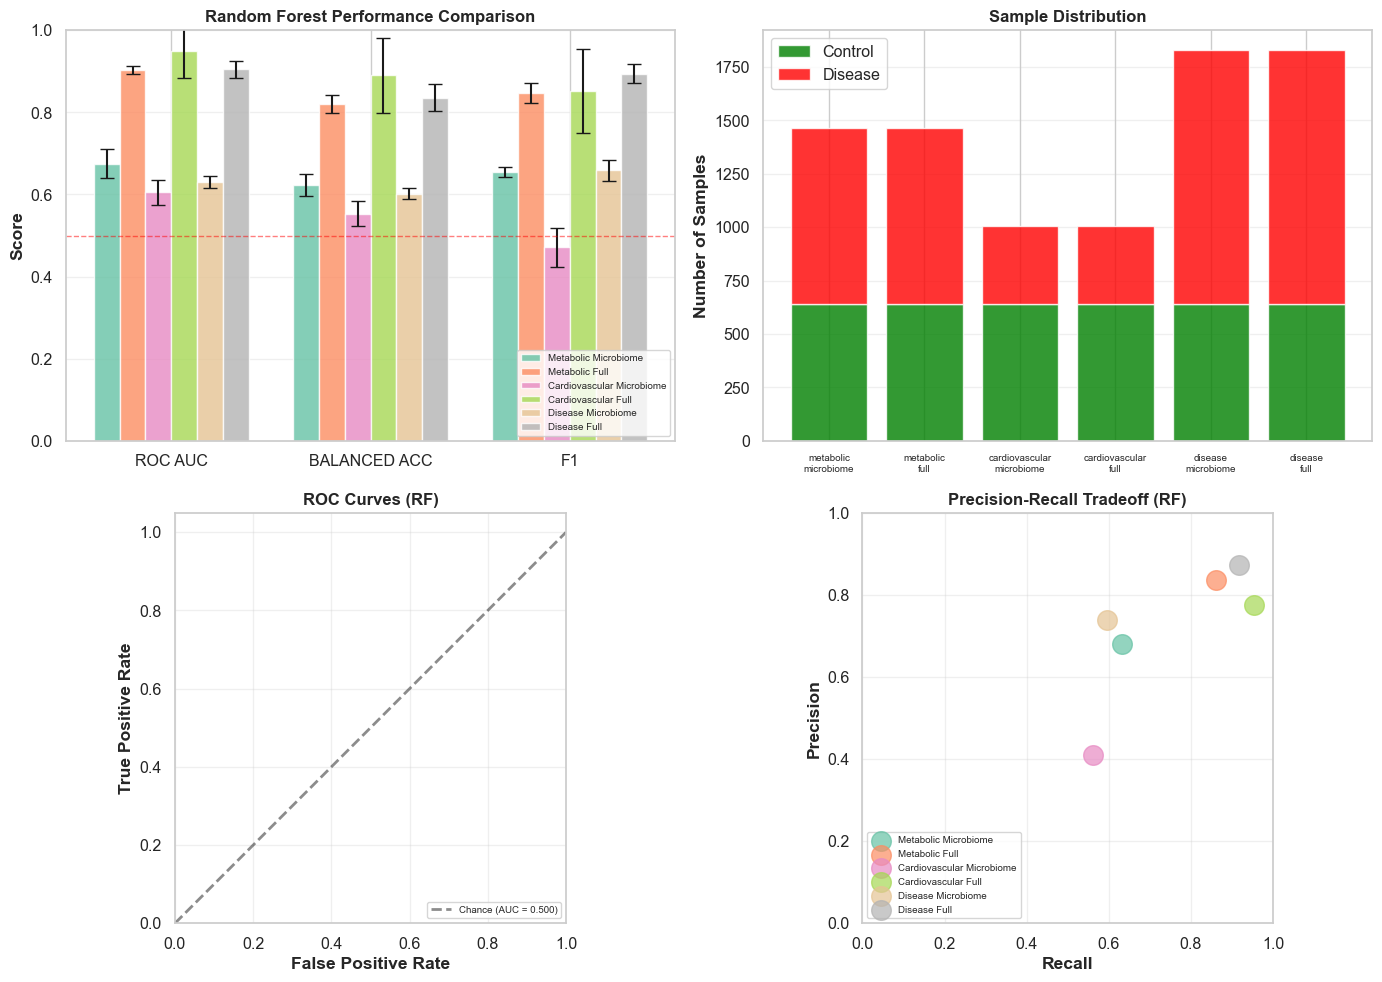

In [28]:
def plot_model_comparison(results_dict):
    """
    Create comprehensive comparison plots for all Random Forest models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    models = list(results_dict.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    # 1. Performance metrics comparison
    ax = axes[0, 0]
    x = np.arange(len(metrics))
    width = 0.13
    for i, (model_name, color) in enumerate(zip(models, colors)):
        values = [results_dict[model_name]['cv_results'][m]['test_mean'] for m in metrics]
        errors = [results_dict[model_name]['cv_results'][m]['test_std'] for m in metrics]
        ax.bar(x + i*width, values, width, yerr=errors,
               label=model_name.replace('_', ' ').title(),
               alpha=0.8, capsize=5, color=color)
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Random Forest Performance Comparison', fontweight='bold', fontsize=12)
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right', fontsize=7)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    # 2. Sample sizes
    ax = axes[0, 1]
    sample_data = []
    for model_name in models:
        sample_data.append({
            'model': model_name.replace('_', '\n'),
            'control': results_dict[model_name]['n_control'],
            'disease': results_dict[model_name]['n_disease']
        })
    df_samples = pd.DataFrame(sample_data)
    x_pos = np.arange(len(df_samples))
    ax.bar(x_pos, df_samples['control'], label='Control', alpha=0.8, color='green')
    ax.bar(x_pos, df_samples['disease'], bottom=df_samples['control'],
           label='Disease', alpha=0.8, color='red')
    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title('Sample Distribution', fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=7)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 3. ROC Curves
    ax = axes[1, 0]
    for i, (model_name, color) in enumerate(zip(models, colors)):
        # Check if ROC curve data is stored
        if 'roc_curve' in results_dict[model_name]:
            fpr = results_dict[model_name]['roc_curve']['fpr']
            tpr = results_dict[model_name]['roc_curve']['tpr']
            auc_score = results_dict[model_name]['cv_results']['roc_auc']['test_mean']
            ax.plot(fpr, tpr, color=color, lw=2, alpha=0.8,
                   label=f"{model_name.replace('_', ' ').title()} (AUC = {auc_score:.3f})")
    
    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Chance (AUC = 0.500)')
    
    ax.set_xlabel('False Positive Rate', fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontweight='bold')
    ax.set_title('ROC Curves (RF)', fontweight='bold', fontsize=12)
    ax.legend(fontsize=7, loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect('equal')
    
    # 4. Precision-Recall
    ax = axes[1, 1]
    for i, (model_name, color) in enumerate(zip(models, colors)):
        precision = results_dict[model_name]['cv_results']['precision']['test_mean']
        recall = results_dict[model_name]['cv_results']['recall']['test_mean']
        ax.scatter(recall, precision, s=200, alpha=0.7, color=color,
                  label=model_name.replace('_', ' ').title())
    ax.set_xlabel('Recall', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall Tradeoff (RF)', fontweight='bold', fontsize=12)
    ax.legend(fontsize=7, loc='lower left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'rf_model_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison(results)

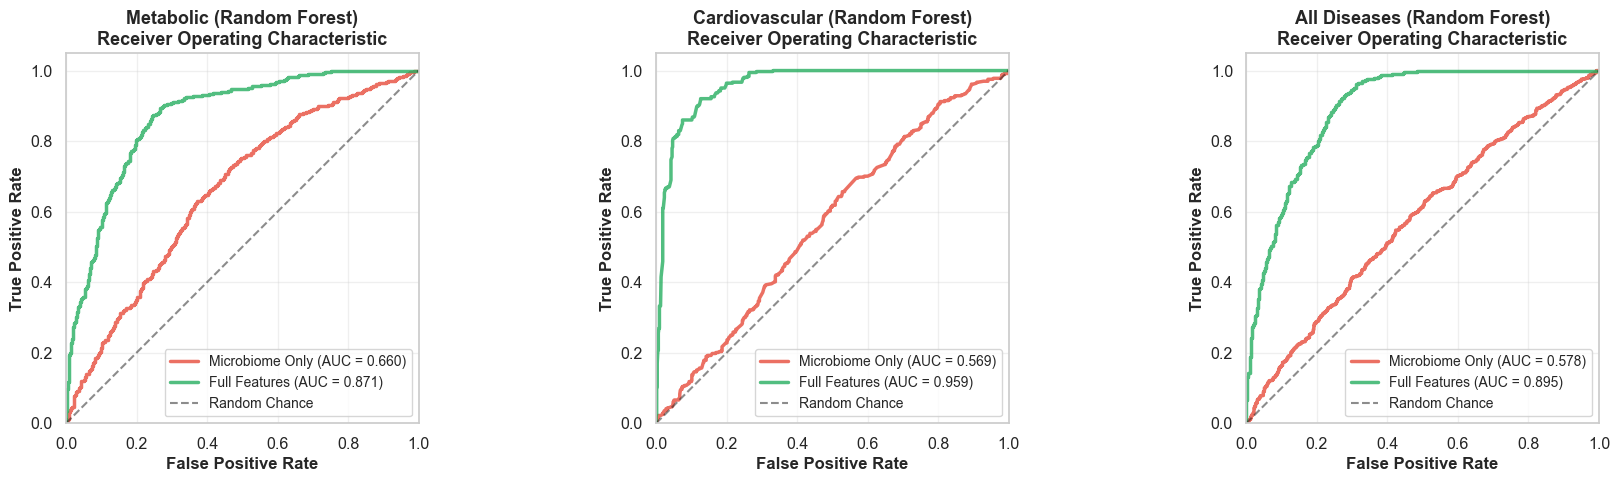


ROC-AUC CURVES GENERATED (Random Forest)
✓ Saved: rf_roc_curves_all_models.png


In [29]:
def plot_roc_curves(results_dict):
    """
    Plot ROC curves for all Random Forest models using cross-validation.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Group models by disease type
    disease_groups = {
        'Metabolic': ['metabolic_microbiome', 'metabolic_full'],
        'Cardiovascular': ['cardiovascular_microbiome', 'cardiovascular_full'],
        'All Diseases': ['disease_microbiome', 'disease_full']
    }

    colors = {'microbiome': '#E74C3C', 'full': '#27AE60'}

    for ax, (disease_name, model_keys) in zip(axes, disease_groups.items()):
        for model_key in model_keys:
            if model_key not in results_dict:
                continue

            result = results_dict[model_key]
            model = result['model']
            X_train = result['X_train']
            y_train = result['y_train']

            # Get probability predictions using cross-validation
            y_proba = cross_val_predict(
                model, X_train.values, y_train,
                cv=5, method='predict_proba', n_jobs=-1
            )[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_train, y_proba)
            roc_auc = auc(fpr, tpr)

            # Determine color and label
            color = colors['full'] if 'full' in model_key else colors['microbiome']
            label_type = 'Full Features' if 'full' in model_key else 'Microbiome Only'

            # Plot
            ax.plot(fpr, tpr, color=color, lw=2.5, alpha=0.8,
                   label=f'{label_type} (AUC = {roc_auc:.3f})')

        # Plot diagonal reference line
        ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Chance')

        # Formatting
        ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        ax.set_title(f'{disease_name} (Random Forest)\nReceiver Operating Characteristic',
                    fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(alpha=0.3)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'rf_roc_curves_all_models.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*70)
    print("ROC-AUC CURVES GENERATED (Random Forest)")
    print("="*70)
    print("✓ Saved: rf_roc_curves_all_models.png")

# Generate ROC curves
plot_roc_curves(results)


In [30]:
# Save feature importance for each model
for model_name, result in results.items():
    if result['feature_importance'] is not None:
        filename = f'feature_importance_{model_name}.csv'
        result['feature_importance'].to_csv(
            os.path.join(ML_TABLES, filename),
            index=False
        )
        print(f"  Saved: {filename}")

  Saved: feature_importance_metabolic_microbiome.csv
  Saved: feature_importance_metabolic_full.csv
  Saved: feature_importance_cardiovascular_microbiome.csv
  Saved: feature_importance_cardiovascular_full.csv
  Saved: feature_importance_disease_microbiome.csv
  Saved: feature_importance_disease_full.csv
